In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image


np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [2]:
CATEGORIES = ["Melanocytic_nevi","melanoma","Benign_keratosis-like_lesions","Basal_cell_carcinoma","Actinic_keratoses","Vascular_lesions","Dermatofibroma"]

lesion_danger = [0, 1, 0, 1, 1,  0, 0]

In [3]:
path = '/Users/florianherrmann/Documents/UNI/Master/DD2/ML/HK/Skin-Lesions-Detection/dataverse_files'

size = 100

In [4]:
skin_df = pd.read_csv(path + '/HAM10000_metadata.csv')

In [5]:
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [6]:
skin_df['label'] = le.transform(skin_df['dx'])
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization        dataset  label  
1617             face   vidir_modern      4  
8128  lower extremity    vienna_dias      5  
2168             back      rosendahl      4  
1090            trunk  vidir_molemax      2  
7754          abdomen   vidir_modern      5  
8071    

/Users/florianherrmann/Downloads/a/envs/mlp/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


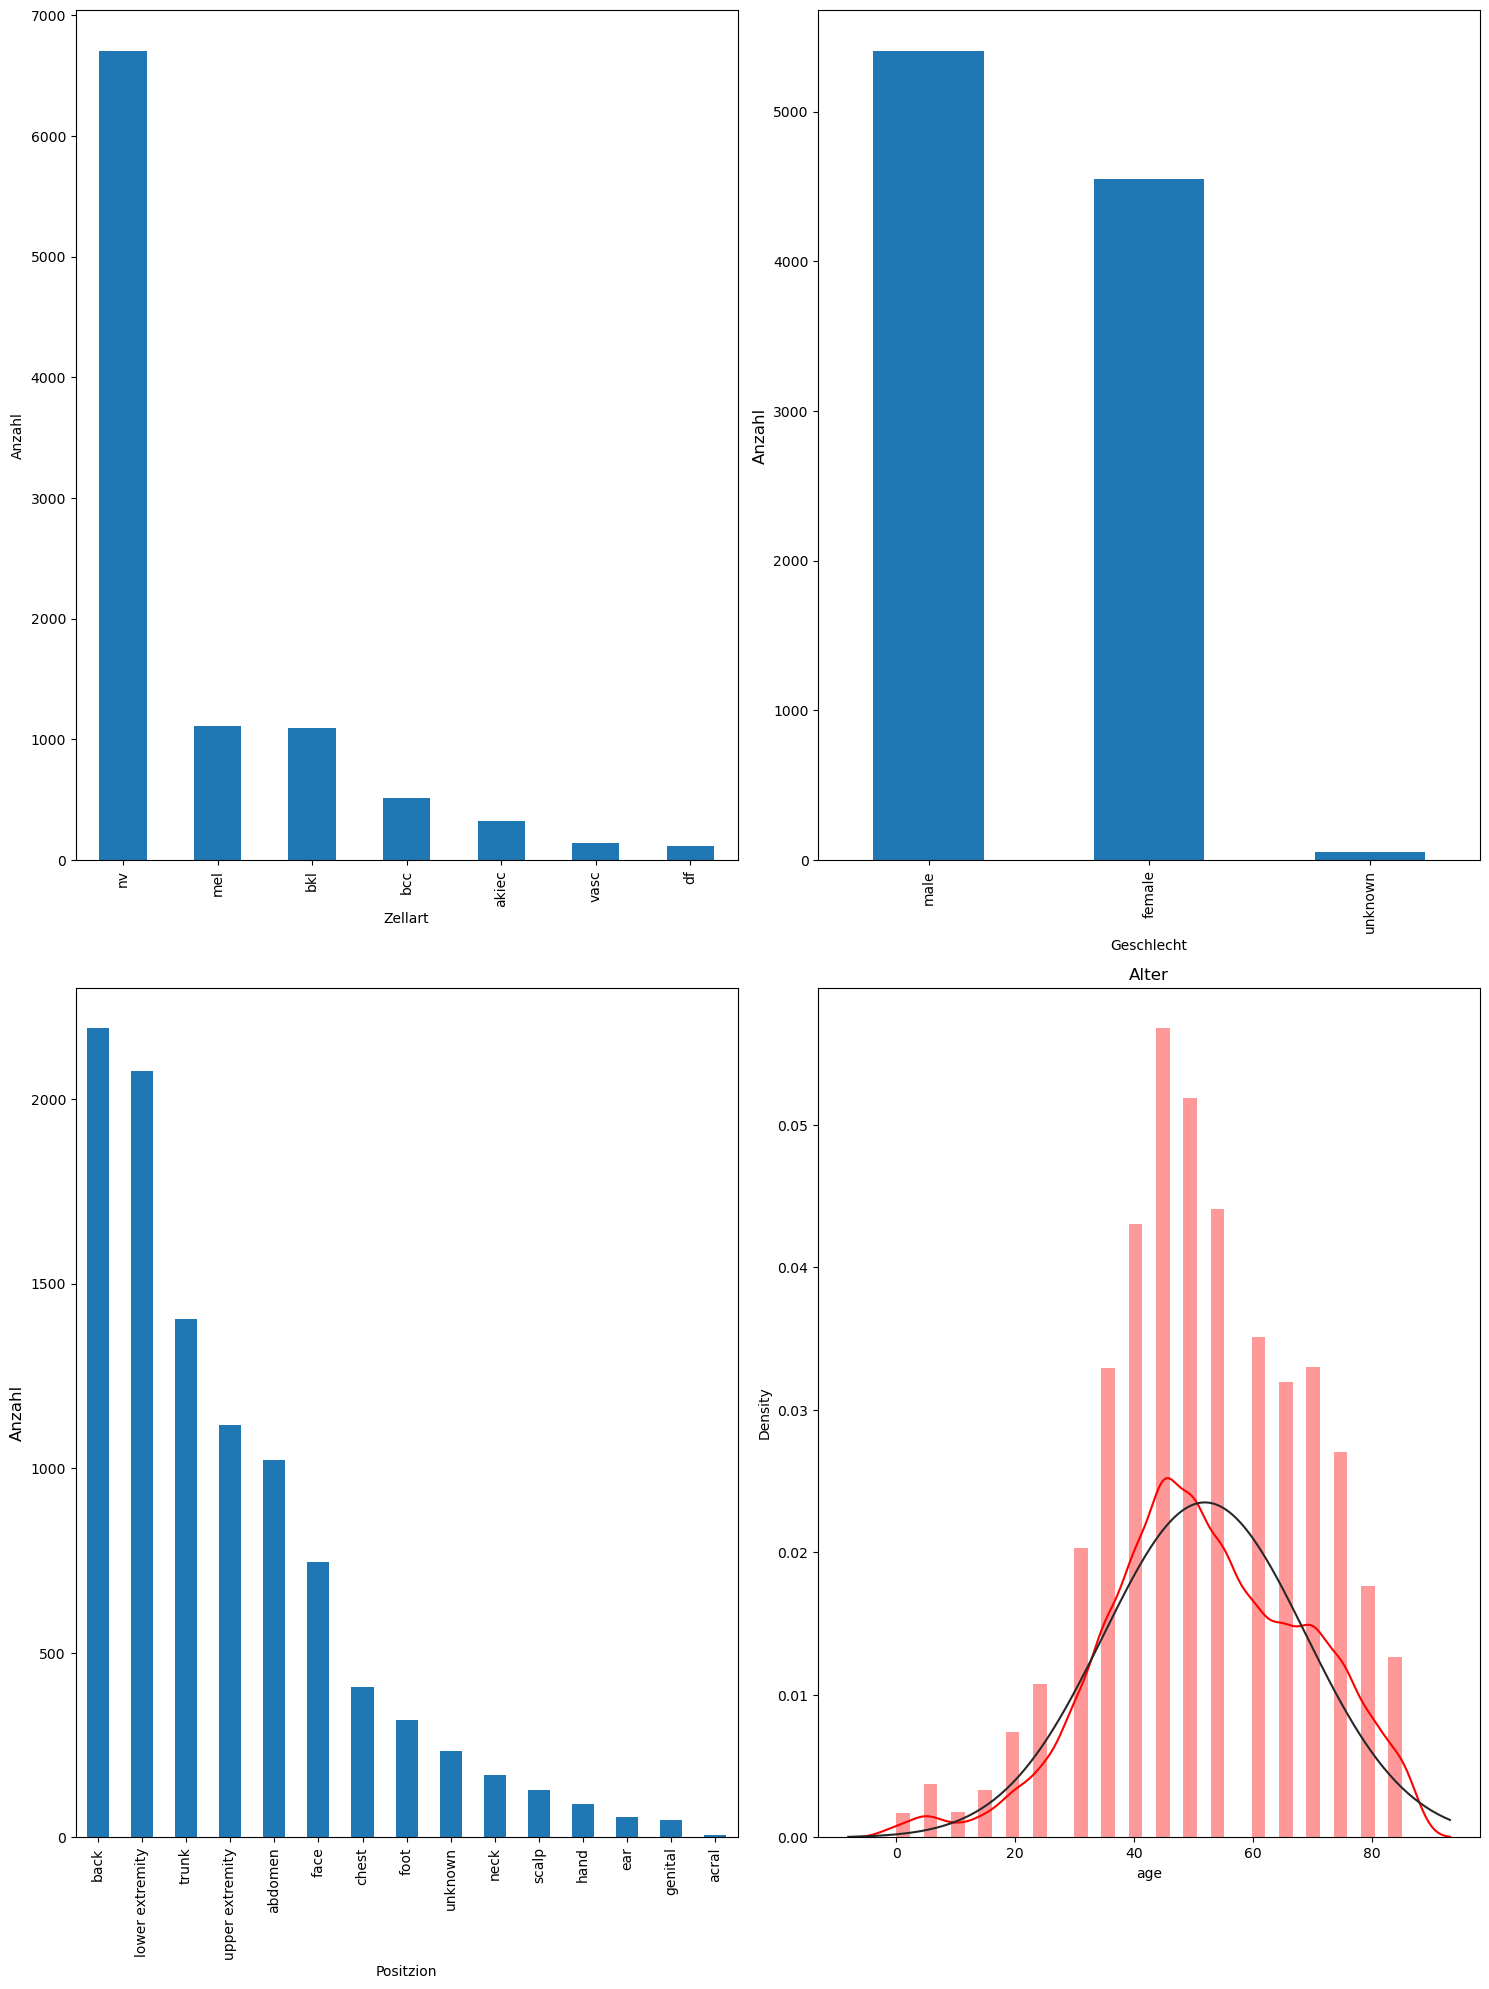

In [7]:
fig = plt.figure(figsize=(15,20))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax = ax1)
ax1.set_ylabel('Anzahl')
ax1.set_xlabel('Zellart');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax = ax2)
ax2.set_ylabel('Anzahl', size = 12)
ax2.set_xlabel('Geschlecht');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Anzahl', size = 12)
ax3.set_xlabel('Positzion');

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Alter')

plt.tight_layout()
plt.show()

In [8]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [9]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples = 1000

In [10]:
df_0_blc = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_blc = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_blc = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_blc = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_blc = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_blc = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_blc = resample(df_6, replace=True, n_samples=n_samples, random_state=42)
skin_df_blc = pd.concat([df_0_blc, df_1_blc, df_2_blc, df_3_blc, df_4_blc, df_5_blc, df_6_blc])

In [11]:
print(skin_df_blc['label'].value_counts( ))

0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
Name: label, dtype: int64


In [12]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(path, '*', '*.jpg'))}
  
image_path

{'ISIC_0026784': '/Users/florianherrmann/Documents/UNI/Master/DD2/ML/HK/Skin-Lesions-Detection/dataverse_files/All_Data/ISIC_0026784.jpg',
 'ISIC_0028971': '/Users/florianherrmann/Documents/UNI/Master/DD2/ML/HK/Skin-Lesions-Detection/dataverse_files/All_Data/ISIC_0028971.jpg',
 'ISIC_0026948': '/Users/florianherrmann/Documents/UNI/Master/DD2/ML/HK/Skin-Lesions-Detection/dataverse_files/All_Data/ISIC_0026948.jpg',
 'ISIC_0026790': '/Users/florianherrmann/Documents/UNI/Master/DD2/ML/HK/Skin-Lesions-Detection/dataverse_files/All_Data/ISIC_0026790.jpg',
 'ISIC_0028965': '/Users/florianherrmann/Documents/UNI/Master/DD2/ML/HK/Skin-Lesions-Detection/dataverse_files/All_Data/ISIC_0028965.jpg',
 'ISIC_0025299': '/Users/florianherrmann/Documents/UNI/Master/DD2/ML/HK/Skin-Lesions-Detection/dataverse_files/All_Data/ISIC_0025299.jpg',
 'ISIC_0024839': '/Users/florianherrmann/Documents/UNI/Master/DD2/ML/HK/Skin-Lesions-Detection/dataverse_files/All_Data/ISIC_0024839.jpg',
 'ISIC_0024811': '/Users/fl

In [13]:
skin_df_blc['path'] = skin_df['image_id'].map(image_path.get)

In [14]:
skin_df_blc['image'] = skin_df_blc['path'].map(lambda x: np.asarray(Image.open(x).resize((size,size))))

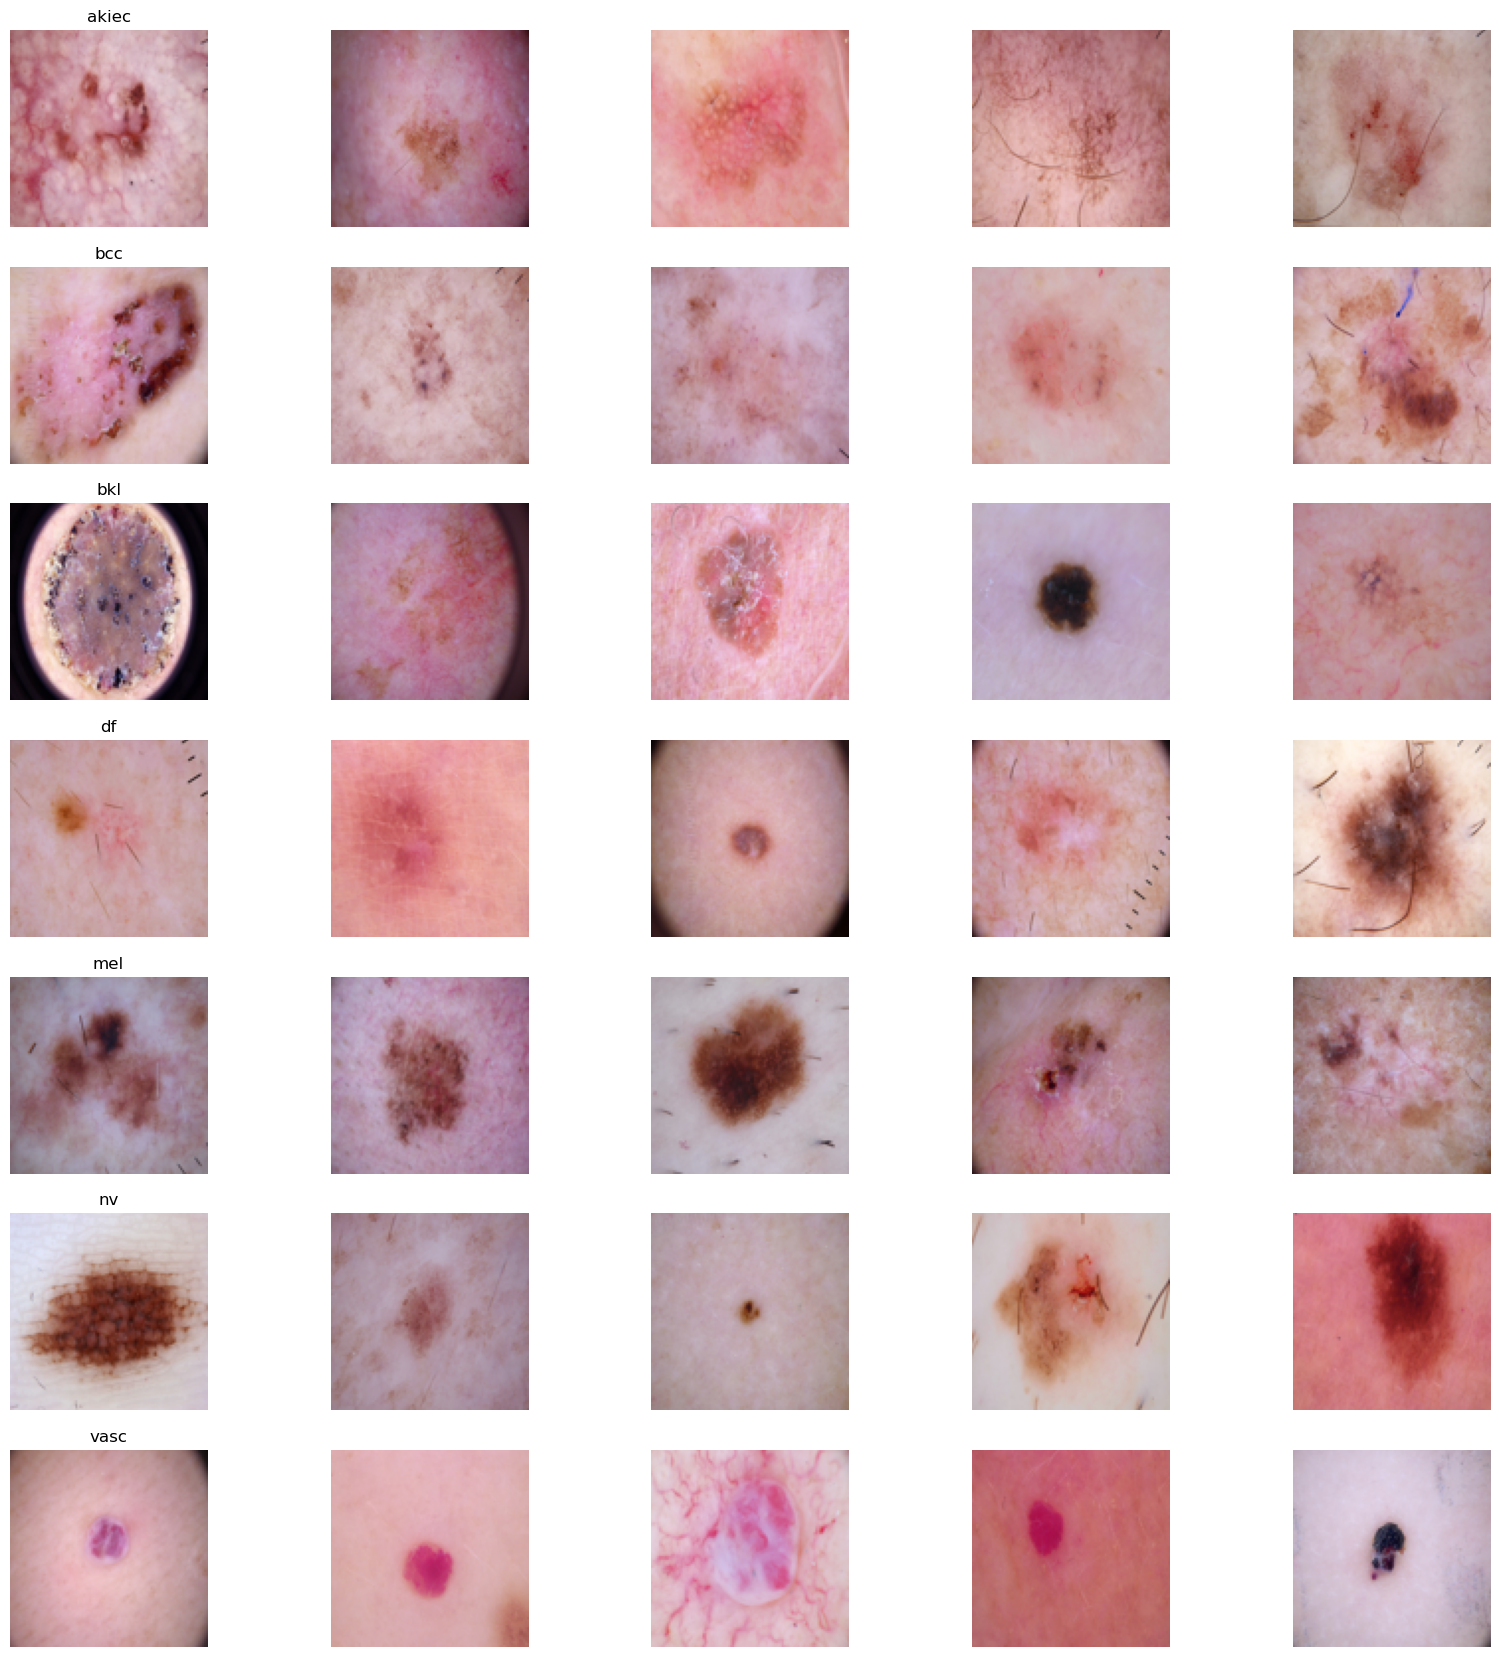

In [15]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,skin_df_blc.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [16]:
X = np.asarray(skin_df_blc['image'].tolist())
X = X/255
Y = skin_df_blc['label']
Y_cat = to_categorical(Y, num_classes=7)

In [17]:
X_train, X_test, Y_Train, Y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [18]:
num_class = 7

model = Sequential()
model.add(Conv2D(256,(3,3), activation="relu", input_shape=(size,size,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

batch_size = 16
epochs = 50


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)  

2022-12-12 10:30:34.955290: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 10:30:34.955881: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
history = model.fit(X_train, Y_Train,
                   epochs=epochs, 
                   batch_size= batch_size,
                   validation_data=(X_test, Y_test),
                   verbose=2)

score = model.evaluate(X_test, Y_test)
print('Genauigkeit: ' , score[1])

Epoch 1/50


2022-12-12 10:30:36.047833: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-12 10:30:36.249353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 10:30:53.452226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


329/329 - 19s - loss: 1.9645 - acc: 0.1419 - val_loss: 1.9472 - val_acc: 0.1331 - 19s/epoch - 58ms/step
Epoch 2/50
329/329 - 18s - loss: 1.9468 - acc: 0.1411 - val_loss: 1.9471 - val_acc: 0.1417 - 18s/epoch - 53ms/step
Epoch 3/50
329/329 - 18s - loss: 1.9470 - acc: 0.1350 - val_loss: 1.9472 - val_acc: 0.1331 - 18s/epoch - 54ms/step
Epoch 4/50
329/329 - 18s - loss: 1.9466 - acc: 0.1423 - val_loss: 1.9466 - val_acc: 0.1497 - 18s/epoch - 54ms/step
Epoch 5/50
329/329 - 17s - loss: 1.9467 - acc: 0.1347 - val_loss: 1.9473 - val_acc: 0.1331 - 17s/epoch - 53ms/step
Epoch 6/50
329/329 - 18s - loss: 1.9472 - acc: 0.1358 - val_loss: 1.9483 - val_acc: 0.1331 - 18s/epoch - 54ms/step
Epoch 7/50
329/329 - 18s - loss: 1.9358 - acc: 0.1493 - val_loss: 1.9709 - val_acc: 0.1691 - 18s/epoch - 54ms/step
Epoch 8/50
329/329 - 18s - loss: 1.8325 - acc: 0.2347 - val_loss: 1.6985 - val_acc: 0.2840 - 18s/epoch - 54ms/step
Epoch 9/50
329/329 - 18s - loss: 1.6728 - acc: 0.2956 - val_loss: 1.6626 - val_acc: 0.3366 

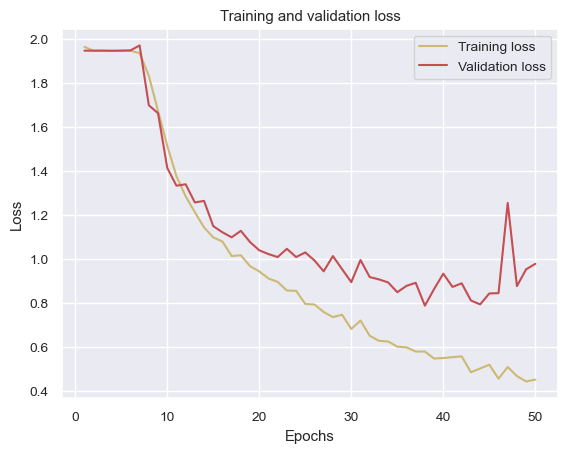

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot (epochs, loss,'y', label="Training loss")
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()
plt.close()

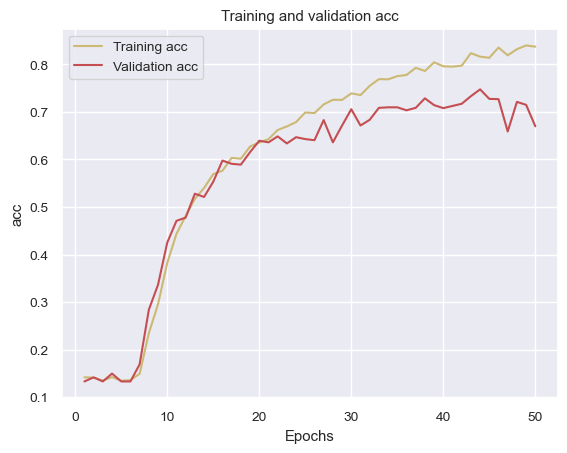

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot (epochs, acc,'y', label="Training acc")
plt.plot(epochs, val_acc,'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.savefig('acc.png')
plt.show()
plt.close()

55/55 [==============================] - 2s 30ms/step


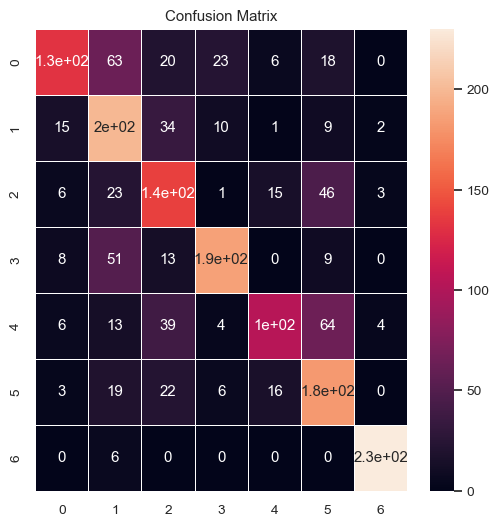

In [38]:
Y_pred = model.predict(X_test)
Y_pred_clases =np.argmax(Y_pred,axis=1)
Y_true =np.argmax(Y_test,axis=1)
cm = confusion_matrix(Y_true, Y_pred_clases)


fig, ax = plt.subplots (figsize=(6,6))
sns.set (font_scale=0.9)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
plt.title('Confusion Matrix')
plt.savefig('confusion.png')
plt.show()
plt.close()

In [26]:
model.save('256x3_128x3_64x3-CNN.model')

INFO:tensorflow:Assets written to: 256x3_128x3_64x3-CNN.model/assets


INFO:tensorflow:Assets written to: 256x3_128x3_64x3-CNN.model/assets


In [27]:
import numpy as np
from PIL import Image
import tensorflow as tf

CATEGORIES = ["Melanocytic_nevi","melanoma","Benign_keratosis-like_lesions","Basal_cell_carcinoma","Actinic_keratoses","Vascular_lesions","Dermatofibroma"]
size = 100

lesion_danger = [0, 1, 0, 1, 1,  0, 0]

model = tf.keras.models.load_model("256x3_128x3_64x3-CNN.model")


def prepare(filepath):
    IMG_SIZE = 100  # 50 in txt-based
    new_array = np.asarray(Image.open(filepath).resize((size,size)))  # resize image to match model's expected sizing
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    
def predict(filepath):
    prediction = model.predict([prepare(filepath)])
    print(prediction)  # will be a list in a list.
    print("The lesion is Probably: "+ CATEGORIES[int(prediction[0][0])])
    print("The danger is: "+ str(lesion_danger[int(prediction[0][0])]))
predict("/Users/florianherrmann/Documents/UNI/Master/DD2/ML/HK/Skin-Lesions-Detection/MM5.jpg")

1/1 [==============================] - 0s 67ms/step
[[0. 0. 0. 1. 0. 0. 0.]]
The lesion is Probably: Melanocytic_nevi
The danger is: 0


2022-12-12 10:46:41.786092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [28]:
from keras_visualizer import visualizer 
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
visualizer(model, format='png', view=True)


In [29]:
from sklearn.metrics import plot_confusion_matrix

In [30]:
plot_confusion_matrix(model, X_test, Y_test)

/Users/florianherrmann/Downloads/a/envs/mlp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


ValueError: plot_confusion_matrix only supports classifiers